## Базовый анализ и расширение данных

In [1]:
#Импорт модулей
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

In [2]:
#Чтение файла
taxi_data = pd.read_csv(r"d:\IDE_github\mathml\data\train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах

### Временные рамки

In [3]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
min_data = min(taxi_data['pickup_datetime'].values)
max_data = max(taxi_data['pickup_datetime'].values)
print(f'Временные рамки:\nрання дата {min_data}\nпоздняя дата {max_data}')

Временные рамки:
рання дата 2016-01-01T00:00:17.000000000
поздняя дата 2016-06-30T23:59:39.000000000


### Пропущенные значения

In [4]:
empty_values_sum = taxi_data.isna().sum()
#Столбцы с пропусками
columns_with_missing = empty_values_sum[empty_values_sum > 0]
if columns_with_missing.empty:
    print('Пропусков в данных нет')
else:
    print('Столбцы с пропусками:')
    for column, count in columns_with_missing.items():
        print(f'  {column}: {count} пропусков')

Пропусков в данных нет


### Статистические характеристики

In [5]:
#Количество уникальных таксопарков
unique_vendors = taxi_data['vendor_id'].nunique()
print(f"Уникальных таксопарков: {unique_vendors}")
#Максимальное количество пассажиров
max_passengers = taxi_data['passenger_count'].max()
print(f"Максимальное количество пассажиров: {max_passengers}")
#Средняя и медианная длительность поездки (округлено до целого)
mean_duration = round(taxi_data['trip_duration'].mean())
median_duration = round(taxi_data['trip_duration'].median())
print(f"Средняя длительность: {mean_duration} секунд")
print(f"Медианная длительность: {median_duration} секунд")
#Минимальное и максимальное время поездки
min_duration = taxi_data['trip_duration'].min()
max_duration = taxi_data['trip_duration'].max()
print(f"Минимальное время поездки: {min_duration} секунд")
print(f"Максимальное время поездки: {max_duration} секунд")

Уникальных таксопарков: 2
Максимальное количество пассажиров: 9
Средняя длительность: 959 секунд
Медианная длительность: 662 секунд
Минимальное время поездки: 1 секунд
Максимальное время поездки: 3526282 секунд


Судя по последним характеристикам, в данных есть выбросы

### Даты поездок

In [6]:
def add_datetime_features(df):
    """
    Добавляет в DataFrame признаки из datetime.
    Parameters:
    df (pd.DataFrame): Исходный DataFrame с колонкой 'pickup_datetime'
    Returns:
    pd.DataFrame: DataFrame с добавленными колонками
    """
    #Создаем копию DataFrame чтобы избежать предупреждений
    df = df.copy()
    #Добавляем новые признаки
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek  # 0-понедельник, 6-воскресенье
    return df

#Применяем функцию к данным
taxi_data = add_datetime_features(taxi_data)

#Поездки в субботу (день недели = 5, т.к. понедельник=0, воскресенье=6)
saturday_trips = taxi_data[taxi_data['pickup_day_of_week'] == 5].shape[0]
print(f"Поездок в субботу: {saturday_trips}")
#Среднее количество поездок в день
trips_per_day = taxi_data.groupby('pickup_date').size()  #Количество поездок по дням
avg_trips_per_day = round(trips_per_day.mean())
print(f"Среднее количество поездок в день: {avg_trips_per_day}")

Поездок в субботу: 220868
Среднее количество поездок в день: 8015


### Создание признаков на датасете о праздниках

In [7]:
holiday_data = pd.read_csv(r'd:\IDE_github\mathml\data\holiday_data.csv', sep=';')
def add_holiday_features(taxi_df, holiday_df):
    """
    Добавляет признак праздничного дня в DataFrame с поездками.
    
    Parameters:
    taxi_df (pd.DataFrame): DataFrame с поездками и колонкой 'pickup_date'
    holiday_df (pd.DataFrame): DataFrame с праздничными днями
    
    Returns:
    pd.DataFrame: DataFrame с добавленным столбцом 'pickup_holiday'
    """
    #Создаем копию чтобы избежать предупреждений
    taxi_df = taxi_df.copy()
    #Преобразование в формат .datetime
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    #Создаем множество праздничных дат для быстрого поиска
    holiday_dates = set(holiday_df['date'].dt.date)
    #Добавляем бинарный признак праздника
    taxi_df['pickup_holiday'] = taxi_df['pickup_datetime'].dt.date.isin(holiday_dates).astype(int)
    return taxi_df

#Применяем функцию к данным
taxi_data = add_holiday_features(taxi_data, holiday_data)

#Фильтруем только праздничные поездки и вычисляем медиану
holiday_trips = taxi_data[taxi_data['pickup_holiday'] == 1]
median_holiday_duration = round(holiday_trips['trip_duration'].median())
print(f"Медианная длительность поездки в праздничные дни: {median_holiday_duration} секунд")

Медианная длительность поездки в праздничные дни: 585 секунд


### Оптимальный путь из точек

In [8]:
osrm_data = pd.read_csv(r'd:\IDE_github\mathml\data\osrm_data_train.csv')

def add_osrm_features(taxi_df, osrm_df):
    """
    Добавляет OSRM-признаки в DataFrame с поездками.
    
    Parameters:
    taxi_df (pd.DataFrame): DataFrame с поездками
    osrm_df (pd.DataFrame): DataFrame с OSRM данными
    
    Returns:
    pd.DataFrame: DataFrame с добавленными OSRM столбцами
    """
    #Создаем копию чтобы избежать предупреждений
    taxi_df = taxi_df.copy()
    #Объединяем таблицы по id поездки
    taxi_df = taxi_df.merge(
        osrm_df[['id', 'total_distance', 'total_travel_time', 'number_of_steps']],
        on='id',
        how='left'  #left join чтобы сохранить все поездки из taxi_df
    )
    return taxi_df

#Применяем функцию к данным
taxi_data = add_osrm_features(taxi_data, osrm_data)

In [9]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    #Переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    #Радиус земли в километрах
    EARTH_RADIUS = 6371 
    #Считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    #Переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    #Считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [10]:
#Разница между медианной длительностью поездки в данных и из OSRM
median_actual = taxi_data['trip_duration'].median()
median_osrm = taxi_data['total_travel_time'].median()
median_difference = abs(median_actual - median_osrm)
print(f"Разница между медианными длительностями: {median_difference:.0f} секунд")
#Количество пропусков в OSRM столбцах
missing_osrm = taxi_data[['total_distance', 'total_travel_time', 'number_of_steps']].isna().sum()
print("\nПропуски в OSRM столбцах:")
for col, count in missing_osrm.items():
    print(f"   {col}: {count} пропусков")

Разница между медианными длительностями: 372 секунд

Пропуски в OSRM столбцах:
   total_distance: 1 пропусков
   total_travel_time: 1 пропусков
   number_of_steps: 1 пропусков


### Расстояние Хаверсина

In [11]:
def add_geographical_features(df):
    """
    Добавляет географические признаки в DataFrame с поездками.
    
    Parameters:
    df (pd.DataFrame): DataFrame с колонками координат
    
    Returns:
    pd.DataFrame: DataFrame с добавленными географическими признаками
    """
    #Создаем копию чтобы избежать предупреждений
    df = df.copy()
    #Добавляем расстояние Хаверсина
    df['haversine_distance'] = get_haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )
    #Добавляем направление движения
    df['direction'] = get_angle_direction(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )
    return df

#Применяем функцию к данным
taxi_data = add_geographical_features(taxi_data)

#Вычисляем медианное расстояние
median_haversine = taxi_data['haversine_distance'].median()
print(f"Медианное расстояние Хаверсина: {median_haversine:.2f} км")

Медианное расстояние Хаверсина: 2.09 км


### Кластеризация

In [12]:
#Создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
#Обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

from sklearn import cluster
def add_cluster_features(df, kmeans_model):
    """
    Добавляет кластерные признаки в DataFrame с поездками.
    
    Parameters:
    df (pd.DataFrame): DataFrame с колонками координат
    kmeans_model: Обученная модель KMeans
    
    Returns:
    pd.DataFrame: DataFrame с добавленным столбцом geo_cluster
    """
    #Создаем копию чтобы избежать предупреждений
    df = df.copy()
    #Создаем матрицу координат для предсказания
    coords_for_prediction = np.hstack((
        df[['pickup_latitude', 'pickup_longitude']],
        df[['dropoff_latitude', 'dropoff_longitude']]
    ))
    #Предсказываем кластеры для всех поездок
    df['geo_cluster'] = kmeans_model.predict(coords_for_prediction)
    
    return df

#Применяем функцию к данным
taxi_data = add_cluster_features(taxi_data, kmeans)
#Считаем количество поездок в каждом кластере
cluster_counts = taxi_data['geo_cluster'].value_counts()
#Находим размер наименьшего кластера
min_cluster_size = cluster_counts.min()
min_cluster_id = cluster_counts.idxmin()
print(f"Размеры кластеров:")
print(cluster_counts)
print(f"\nНаименьший кластер (ID {min_cluster_id}) содержит {min_cluster_size} поездок")

Размеры кластеров:
geo_cluster
0    595850
6    405045
9    322999
7     45791
3     40671
2     32769
8     15510
4         4
5         3
1         2
Name: count, dtype: int64

Наименьший кластер (ID 1) содержит 2 поездок


### Данные о погоде

In [13]:
weather_data = pd.read_csv(r'd:\IDE_github\mathml\data\weather_data.csv')

def add_weather_features(taxi_df, weather_df):
    """
    Добавляет погодные признаки в DataFrame с поездками.
    
    Parameters:
    taxi_df (pd.DataFrame): DataFrame с поездками и колонкой 'pickup_datetime'
    weather_df (pd.DataFrame): DataFrame с погодными данными
    
    Returns:
    pd.DataFrame: DataFrame с добавленными погодными признаками
    """
    #Создаем копию чтобы избежать предупреждений
    taxi_df = taxi_df.copy()
    weather_df = weather_df.copy()
    #Преобразуем даты в datetime
    weather_df['time'] = pd.to_datetime(weather_df['time'])
    #Извлекаем час из времени посадки для объединения
    taxi_df['pickup_hour'] = taxi_df['pickup_datetime'].dt.floor('h')
    #Объединяем таблицы по времени
    taxi_df = taxi_df.merge(
        weather_df[['time', 'temperature', 'visibility', 'wind speed', 'precip', 'events']],
        left_on='pickup_hour',
        right_on='time',
        how='left'
    )
    #Удаляем временные колонки
    taxi_df = taxi_df.drop(['pickup_hour', 'time'], axis=1)
    return taxi_df

taxi_data = add_weather_features(taxi_data, weather_data)
#Поездки в снежную погоду
snow_trips = taxi_data[taxi_data['events'] == 'Snow'].shape[0]
print(f"Поездок в снежную погоду: {snow_trips}")
#Процент пропусков в погодных столбцах
weather_columns = ['temperature', 'visibility', 'wind speed', 'precip', 'events']
total_rows = len(taxi_data)
missing_percentages = {}
for col in weather_columns:
    missing_count = taxi_data[col].isna().sum()
    percentage = (missing_count / total_rows) * 100
    missing_percentages[col] = percentage
print("\nПроцент пропусков в погодных столбцах:")
for col, percentage in missing_percentages.items():
    print(f"   {col}: {percentage:.2f}%")
#Общий процент пропусков (если нужно среднее по всем столбцам)
avg_missing_percentage = np.mean(list(missing_percentages.values()))
print(f"\nСредний процент пропусков: {avg_missing_percentage:.2f}%")

Поездок в снежную погоду: 13126

Процент пропусков в погодных столбцах:
   temperature: 0.82%
   visibility: 0.82%
   wind speed: 0.82%
   precip: 0.82%
   events: 95.10%

Средний процент пропусков: 19.68%


### Заполнение пропущенных значений в данных о поездках

In [14]:
def fill_null_weather_data(df):
    """
    Заполняет пропущенные значения в таблице с данными о поездках.
    
    Parameters:
    df (pd.DataFrame): DataFrame с данными о поездках
    
    Returns:
    pd.DataFrame: DataFrame с заполненными пропусками
    """
    #Создаем копию чтобы избежать предупреждений
    df = df.copy()
    #Заполняем пропуски в погодных столбцах медианой по дате
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in weather_columns:
        #Вычисляем медиану по дате для каждого столбца
        median_by_date = df.groupby('pickup_date')[col].transform('median')
        # Заполняем пропуски медианой по дате
        df[col] = df[col].fillna(median_by_date)
    #Заполняем пропуски в events строкой 'None'
    df['events'] = df['events'].fillna('None')
    #Заполняем пропуски в OSRM столбцах общей медианой
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in osrm_columns:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)
    return df

#Применяем функцию к данным
taxi_data_filled = fill_null_weather_data(taxi_data)

#Вычисляем медиану температуры после заполнения пропусков
median_temperature = taxi_data_filled['temperature'].median()
rounded_median = round(median_temperature, 1)
print(f"Медиана температуры после заполнения пропусков: {rounded_median}")

Медиана температуры после заполнения пропусков: 11.1


### Диаграмма рассеяния средней скорости движения

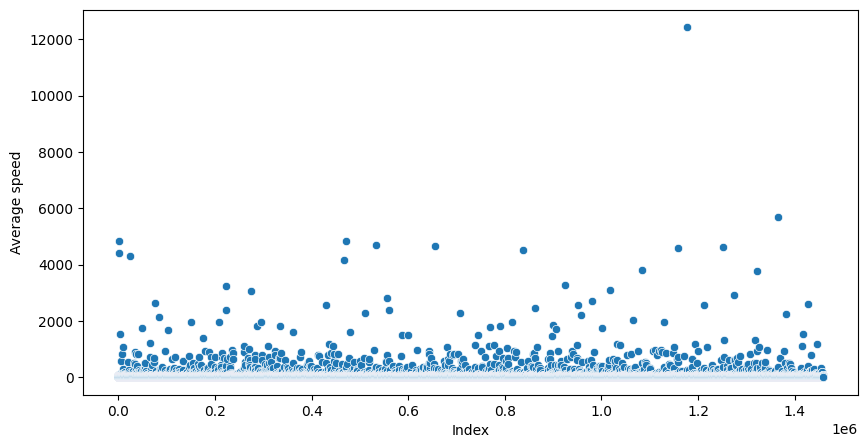

In [15]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

В данных о скорости явно есть выбросы

In [16]:
#Находим и удаляем поездки длительностью более 24 часов (86400 секунд)
long_trip_outliers = taxi_data[taxi_data['trip_duration'] > 86400]
print(f"Количество выбросов по длительности (более 24 часов): {len(long_trip_outliers)}")
#Удаляем эти выбросы
taxi_data_cleaned = taxi_data[taxi_data['trip_duration'] <= 86400].copy()
#Находим и удаляем поездки со средней скоростью более 300 км/ч
#Вычисляем среднюю скорость
taxi_data_cleaned['avg_speed'] = taxi_data_cleaned['total_distance'] / taxi_data_cleaned['trip_duration'] * 3.6
speed_outliers = taxi_data_cleaned[taxi_data_cleaned['avg_speed'] > 300]
print(f"Количество выбросов по скорости (более 300 км/ч): {len(speed_outliers)}")
#Удаляем эти выбросы
taxi_data_final = taxi_data_cleaned[taxi_data_cleaned['avg_speed'] <= 300].copy()
#Удаляем временный столбец avg_speed
taxi_data_final = taxi_data_final.drop('avg_speed', axis=1)
print(f"Размер данных после удаления выбросов: {len(taxi_data_final)} записей")

Количество выбросов по длительности (более 24 часов): 4
Количество выбросов по скорости (более 300 км/ч): 406
Размер данных после удаления выбросов: 1458233 записей


## Разведывательный анализ данных

### Диаграммы зависимости длительности поездки

In [17]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

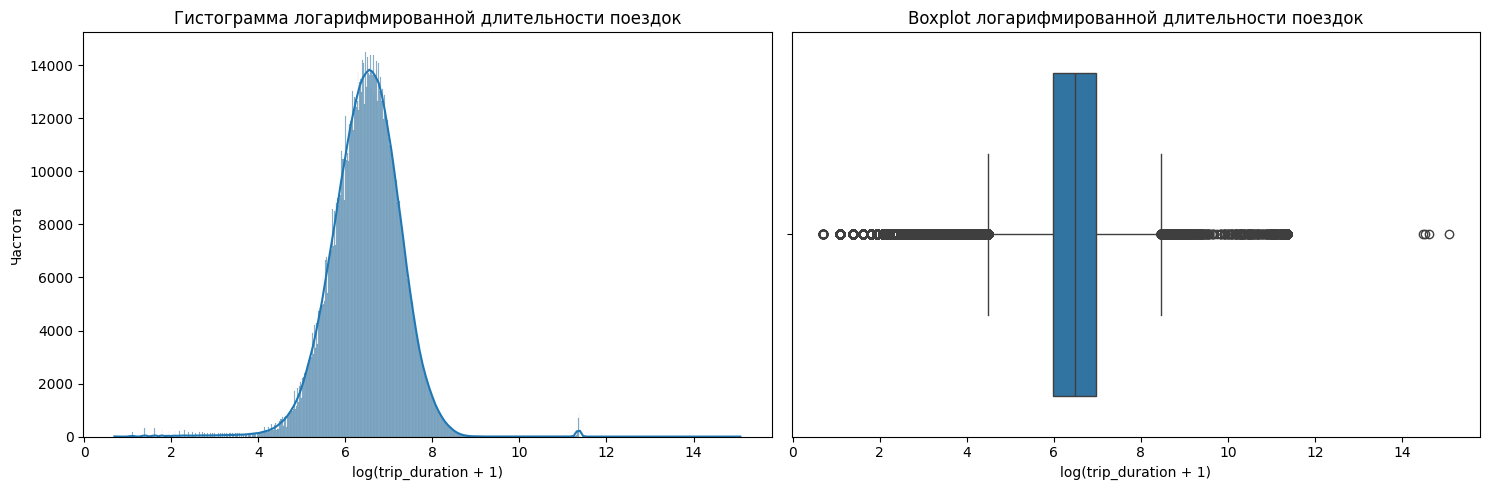

Статистика теста: 148792.91
p-value: 0.00
Распределение НЕ является нормальным (отвергаем нулевую гипотезу)


In [18]:
#Создаем графики
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#Гистограмма с KDE
sns.histplot(taxi_data['trip_duration_log'], kde=True, ax=axes[0])
axes[0].set_title('Гистограмма логарифмированной длительности поездок')
axes[0].set_xlabel('log(trip_duration + 1)')
axes[0].set_ylabel('Частота')
#Коробчатая диаграмма
sns.boxplot(x=taxi_data['trip_duration_log'], ax=axes[1])
axes[1].set_title('Boxplot логарифмированной длительности поездок')
axes[1].set_xlabel('log(trip_duration + 1)')
plt.tight_layout()
plt.show()

#Проводим тест Д'Агостино на нормальность
statistic, p_value = stats.normaltest(taxi_data['trip_duration_log'])
print(f"Статистика теста: {statistic:.2f}")
print(f"p-value: {p_value:.2f}")
#Проверяем гипотезу на уровне значимости α=0.05
alpha = 0.05
if p_value < alpha:
    print("Распределение НЕ является нормальным (отвергаем нулевую гипотезу)")
else:
    print("Распределение является нормальным (не отвергаем нулевую гипотезу)")

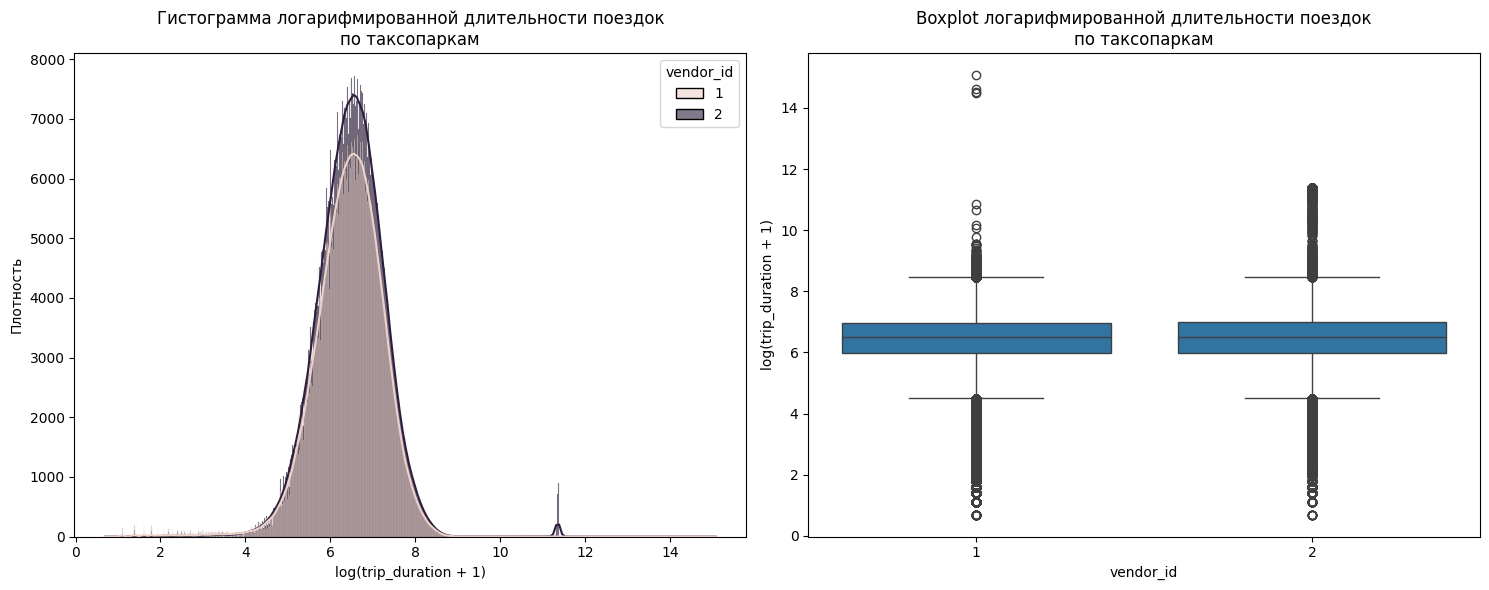

Описательная статистика по таксопаркам:
            count  mean   std   min    max  median
vendor_id                                         
1          678342  6.45  0.79  0.69  15.08    6.49
2          780302  6.48  0.80  0.69  11.37    6.50

T-тест для сравнения средних:
t-статистика: -23.851
p-value: 0.000


In [19]:
#Создаем графики для сравнения распределений по vendor_id
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
#Гистограммы с KDE для каждого vendor_id
sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', 
             kde=True, alpha=0.6, ax=axes[0])
axes[0].set_title('Гистограмма логарифмированной длительности поездок\nпо таксопаркам')
axes[0].set_xlabel('log(trip_duration + 1)')
axes[0].set_ylabel('Плотность')
#Boxplot для каждого vendor_id
sns.boxplot(data=taxi_data, x='vendor_id', y='trip_duration_log', ax=axes[1])
axes[1].set_title('Boxplot логарифмированной длительности поездок\nпо таксопаркам')
axes[1].set_xlabel('vendor_id')
axes[1].set_ylabel('log(trip_duration + 1)')
plt.tight_layout()
plt.show()
# Дополнительная статистика для сравнения
print("Описательная статистика по таксопаркам:")
vendor_stats = taxi_data.groupby('vendor_id')['trip_duration_log'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(2)
print(vendor_stats)
#Проверка статистической значимости различий
from scipy import stats
vendor_1 = taxi_data[taxi_data['vendor_id'] == 1]['trip_duration_log']
vendor_2 = taxi_data[taxi_data['vendor_id'] == 2]['trip_duration_log']
#T-тест для сравнения средних
t_stat, p_value = stats.ttest_ind(vendor_1, vendor_2, equal_var=False)
print(f"\nT-тест для сравнения средних:")
print(f"t-статистика: {t_stat:.3f}")
print(f"p-value: {p_value:.3f}")